In [1]:
# Install the datasets package
!pip install datasets

# Install other necessary packages
!pip install spacy torch transformers scikit-learn

# Download the English spaCy model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-no

In [2]:

import os
import re
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Tokenizer
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader


In [3]:
pip install gensim transformers tensorflow streamlit numpy pandas scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [4]:

def read_story_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    parts = content.split('@highlight')
    article = parts[0].strip()
    highlights = [highlight.strip() for highlight in parts[1:]]
    return article, highlights[0] if highlights else ""

def load_cnn_dailymail_dataset(dataset_path):
    articles = []
    headlines = []
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".story"):
            article, headline = read_story_file(os.path.join(dataset_path, file_name))
            articles.append(article)
            headlines.append(headline)
    return articles, headlines

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()



# Load the dataset
dataset_path = "/content/drive/MyDrive/nlp/extracted/sample"
articles, headlines = load_cnn_dailymail_dataset(dataset_path)
articles = [preprocess_text(article) for article in articles]
headlines = [preprocess_text(headline) for headline in headlines]



In [5]:
articles

['critics of president barack obama s foreign policy are getting louder by the day  and that poses risks for democrats this fall and even in 2016  according to previews of hillary clinton s memoirs   hard choices   the former secretary of state distances herself from obama on certain decisions  such as on the question of whether to arm syrian rebels  she wanted to be more aggressive  he did not  democrats have grown more nervous about foreign policy as obama has been working hard to respond to critics who say has nt taken a toughenough line  the controversy over the deal to secure the release of army sgt bowe bergdahl in exchange for five taliban prisoners has flared into an extraordinarily heated debate  obama has watched as his approval rating for handling international affairs has fallen to 41   last month  obama had to stand by as republicans launched another round of congressional investigations into the deaths of four americans in benghazi  libya  russia s aggressive moves into t

In [6]:
len(articles)

70

In [7]:
headlines

['julian zelizer  criticism of obama foreign policy has been on the increase',
 'new  us coast guard and jamaica suspend search on sunday',
 'the younger generation has not seen pyongyang as a significant threat',
 'world leaders meeting in seoul to discuss security measures against nuclear terrorism',
 'analyst says  greenonblue  attackers are split between infiltrators  disgruntled security',
 'britain s mark cavendish wins world road race title in copenhagen',
 'archery medallists from north and south korea share a podium at asian games',
 'barbers mo and karim nabbach put up a sign about kim jong un s hair',
 'a group of bears attacks a hunting party carrying a deer on sally island  alaska',
 'jeff pearlman says he took a lot of heat for the revelations in his walter payton biography',
 ' been away too long  is the lead single from the first soundgarden album since 1996',
 'uruguay to play peru in semifinals of copa america after eliminating hosts argentina',
 'dev  ellis  frank an

In [8]:
len(headlines)

70

In [9]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel, Word2Vec
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
import streamlit as st

nltk.download('punkt')

def tokenize(text):
    return word_tokenize(text.lower())

# Assuming tokenization is applied earlier
tokenized_articles = [tokenize(article) for article in articles]
tokenized_headlines = [tokenize(headline) for headline in headlines]

dictionary = Dictionary(tokenized_articles)
corpus = [dictionary.doc2bow(article) for article in tokenized_articles]
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=20, iterations=400, random_state=42)

w2v_model = Word2Vec(sentences=tokenized_articles + tokenized_headlines, vector_size=100, window=5, min_count=2, workers=4)

from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Coherence Score: 0.3278533362551752


In [10]:
tokenized_articles

[['critics',
  'of',
  'president',
  'barack',
  'obama',
  's',
  'foreign',
  'policy',
  'are',
  'getting',
  'louder',
  'by',
  'the',
  'day',
  'and',
  'that',
  'poses',
  'risks',
  'for',
  'democrats',
  'this',
  'fall',
  'and',
  'even',
  'in',
  '2016',
  'according',
  'to',
  'previews',
  'of',
  'hillary',
  'clinton',
  's',
  'memoirs',
  'hard',
  'choices',
  'the',
  'former',
  'secretary',
  'of',
  'state',
  'distances',
  'herself',
  'from',
  'obama',
  'on',
  'certain',
  'decisions',
  'such',
  'as',
  'on',
  'the',
  'question',
  'of',
  'whether',
  'to',
  'arm',
  'syrian',
  'rebels',
  'she',
  'wanted',
  'to',
  'be',
  'more',
  'aggressive',
  'he',
  'did',
  'not',
  'democrats',
  'have',
  'grown',
  'more',
  'nervous',
  'about',
  'foreign',
  'policy',
  'as',
  'obama',
  'has',
  'been',
  'working',
  'hard',
  'to',
  'respond',
  'to',
  'critics',
  'who',
  'say',
  'has',
  'nt',
  'taken',
  'a',
  'toughenough',
  'li

In [11]:
tokenized_headlines

[['julian',
  'zelizer',
  'criticism',
  'of',
  'obama',
  'foreign',
  'policy',
  'has',
  'been',
  'on',
  'the',
  'increase'],
 ['new',
  'us',
  'coast',
  'guard',
  'and',
  'jamaica',
  'suspend',
  'search',
  'on',
  'sunday'],
 ['the',
  'younger',
  'generation',
  'has',
  'not',
  'seen',
  'pyongyang',
  'as',
  'a',
  'significant',
  'threat'],
 ['world',
  'leaders',
  'meeting',
  'in',
  'seoul',
  'to',
  'discuss',
  'security',
  'measures',
  'against',
  'nuclear',
  'terrorism'],
 ['analyst',
  'says',
  'greenonblue',
  'attackers',
  'are',
  'split',
  'between',
  'infiltrators',
  'disgruntled',
  'security'],
 ['britain',
  's',
  'mark',
  'cavendish',
  'wins',
  'world',
  'road',
  'race',
  'title',
  'in',
  'copenhagen'],
 ['archery',
  'medallists',
  'from',
  'north',
  'and',
  'south',
  'korea',
  'share',
  'a',
  'podium',
  'at',
  'asian',
  'games'],
 ['barbers',
  'mo',
  'and',
  'karim',
  'nabbach',
  'put',
  'up',
  'a',
  'si

In [12]:
print(dictionary)

Dictionary<7763 unique tokens: ['1966', '1978', '1982', '2002', '2006']...>


In [13]:
corpus

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 26),
  (10, 2),
  (11, 5),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 3),
  (26, 3),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 2),
  (31, 1),
  (32, 1),
  (33, 4),
  (34, 3),
  (35, 4),
  (36, 18),
  (37, 1),
  (38, 1),
  (39, 5),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 16),
  (44, 5),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 4),
  (52, 1),
  (53, 1),
  (54, 3),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 5),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 4),
  (80, 1),
  (81, 8),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 2),
  (90, 1),
  (91,

In [14]:
pip install transformers


In [15]:
import os
import re
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Tokenizer
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader

# Load the spaCy NER model
nlp = spacy.load("en_core_web_sm")

def extract_entities(article):
    doc = nlp(article)
    entities = [ent.text for ent in doc.ents]
    return entities

def extract_topics(article, vectorizer, lda):
    article_vector = vectorizer.transform([article])
    topic_dist = lda.transform(article_vector)
    topic_idx = topic_dist.argmax()
    topic_words = vectorizer.get_feature_names_out()
    return [topic_words[i] for i in lda.components_[topic_idx].argsort()[:-6:-1]]

def get_emoticon(topic):
    emoticons = {
        "politics": ["☺️", "😡", "😠", "💥"],
        "sports": ["⚽", "🏀", "🏈", "🏏", "🎳", "🏆", "🎖️", "🥇"],
        "entertainment": ["🎬", "🎤", "🎭", "🎨", "🖼️"],
        "economy": ["💸", "📉", "📈", "🤑"],
        "technology": ["💻", "📱", "🔌", "🚀"],
        "travel": ["🌎", "🏕️", "🏞️", "🏗️", "🗻"],
        "health": ["🏥", "🚑"],
        "emergency": ["🚒", "🚖"],
        "warning": ["🚭", "🚯", "🚱", "🚷", "📵", "🔞", "🚸", "🚳"]
    }
    if topic in emoticons:
        return random.choice(emoticons[topic])
    return random.choice(["😇", "😊", "😎"])

def generate_template_headline(article, vectorizer, lda):
    entities = extract_entities(article)
    topics = extract_topics(article, vectorizer, lda)
    topic_str = " ".join(topics)

    if topics:
        emoticon = get_emoticon(topics[0])
    else:
        emoticon = get_emoticon("")

    templates = [
        f"{entities[0]} in {topic_str} Scandal {emoticon}" if entities else f"{topic_str} Story {emoticon}",
        f"{entities[0]} Announces New {topic_str} {emoticon}" if entities else f"{topic_str} News {emoticon}"
    ]
    return random.choice(templates)

class HeadlineLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(HeadlineLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x)
        output = self.fc(output)
        return output

class HeadlineDataset(Dataset):
    def __init__(self, articles, headlines, tokenizer):
        max_length = 512
        self.articles = [torch.tensor(tokenizer.encode(article, truncation=True, max_length=max_length)) for article in articles]
        self.headlines = [torch.tensor(tokenizer.encode(headline, truncation=True, max_length=max_length)) for headline in headlines]

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        return self.articles[idx], self.headlines[idx]

# Prepare LDA model
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(articles)
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# Prepare the LSTM model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
vocab_size = len(tokenizer)
model = HeadlineLSTM(vocab_size, 256, 512, vocab_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
dataset = HeadlineDataset(articles, headlines, tokenizer)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
losslist = []
for epoch in range(50):
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, vocab_size)
        labels = labels.view(-1)
        if outputs.shape[0] < labels.shape[0]:
            labels = labels[:outputs.shape[0]]
        elif outputs.shape[0] > labels.shape[0]:
            outputs = outputs[:labels.shape[0]]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losslist.append(loss.item())
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

def refine_headline(article, headline_template):
    input_ids = torch.tensor(tokenizer.encode(headline_template, truncation=True, max_length=512)).unsqueeze(0)
    output = model(input_ids)
    refined_headline = tokenizer.decode(output.argmax(dim=2).squeeze().tolist())
    return refined_headline




/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Epoch 1, Loss: 9.3985595703125
Epoch 2, Loss: 6.346200466156006
Epoch 3, Loss: 5.889380931854248
Epoch 4, Loss: 4.512577533721924
Epoch 5, Loss: 3.1594080924987793
Epoch 6, Loss: 3.067319631576538
Epoch 7, Loss: 0.40194061398506165
Epoch 8, Loss: 1.8281141519546509
Epoch 9, Loss: 0.20952826738357544
Epoch 10, Loss: 2.080747127532959
Epoch 11, Loss: 2.3869640827178955
Epoch 12, Loss: 2.1846671104431152
Epoch 13, Loss: 1.96654212474823
Epoch 14, Loss: 2.180842876434326
Epoch 15, Loss: 0.15541528165340424
Epoch 16, Loss: 2.578141927719116
Epoch 17, Loss: 1.708024024963379
Epoch 18, Loss: 2.714963912963867
Epoch 19, Loss: 1.8526262044906616
Epoch 20, Loss: 2.387803316116333
Epoch 21, Loss: 1.8144959211349487
Epoch 22, Loss: 1.7228293418884277
Epoch 23, Loss: 2.0010900497436523
Epoch 24, Loss: 1.9585508108139038
Epoch 25, Loss: 1.8818897008895874
Epoch 26, Loss: 0.007033840287476778
Epoch 27, Loss: 0.00784352794289589
Epoch 28, Loss: 0.006781446747481823
Epoch 29, Loss: 2.6147725582122803
E

In [19]:
losslist

[10.80565357208252,
 10.825124740600586,
 10.827513694763184,
 10.801259994506836,
 10.843939781188965,
 10.810622215270996,
 10.742693901062012,
 10.81356430053711,
 10.790569305419922,
 10.811906814575195,
 10.738445281982422,
 10.79798412322998,
 10.672652244567871,
 10.755325317382812,
 10.731219291687012,
 10.825226783752441,
 10.734957695007324,
 10.828852653503418,
 10.381529808044434,
 10.520697593688965,
 10.475744247436523,
 10.367329597473145,
 10.19983196258545,
 10.23101806640625,
 10.331073760986328,
 10.035988807678223,
 9.350080490112305,
 10.519630432128906,
 10.004135131835938,
 9.773441314697266,
 9.973443984985352,
 9.123364448547363,
 7.945791244506836,
 9.2583646774292,
 10.551429748535156,
 9.40251350402832,
 9.238892555236816,
 9.316954612731934,
 9.324150085449219,
 9.165366172790527,
 10.639459609985352,
 10.15356159210205,
 10.251387596130371,
 8.523215293884277,
 9.968875885009766,
 9.898618698120117,
 8.088373184204102,
 9.48257827758789,
 10.25051593780517

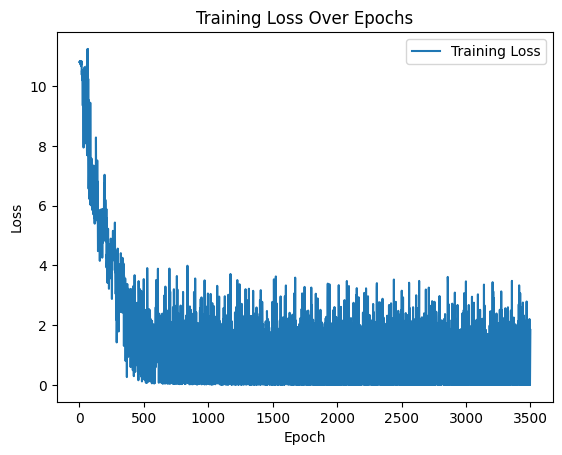

In [20]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(losslist, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


the to of and in Story 😊
former ian native can k killed killed


previous trained losses


In [ ]:
# secret forar vastal civilians killed k

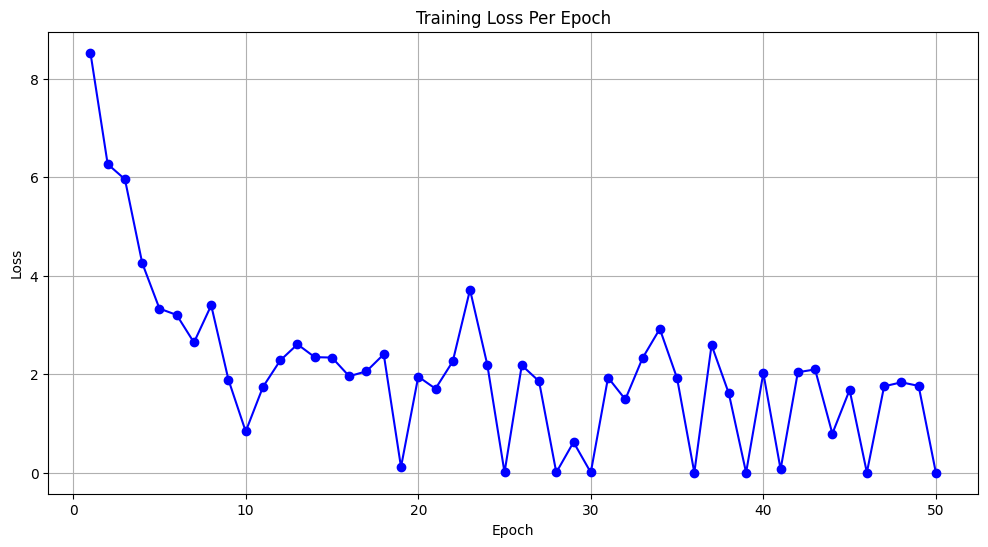

In [ ]:
import matplotlib.pyplot as plt

# List of loss values for each epoch
losses = [
    8.53066349029541, 6.268187522888184, 5.96123743057251, 4.26173210144043,
    3.335125684738159, 3.205763101577759, 2.6468703746795654, 3.4012393951416016,
    1.8898730278015137, 0.8395150303840637, 1.7442148923873901, 2.2819807529449463,
    2.6097867488861084, 2.348940372467041, 2.340569019317627, 1.9610501527786255,
    2.0626749992370605, 2.407264471054077, 0.11735286563634872, 1.95376455783844,
    1.707995057106018, 2.262587547302246, 3.7174580097198486, 2.197885751724243,
    0.007807805202901363, 2.1838784217834473, 1.8596104383468628, 0.007120277266949415,
    0.622934103012085, 0.006755112670361996, 1.9345982074737549, 1.490910530090332,
    2.3295836448669434, 2.9228975772857666, 1.921296238899231, 0.004005715250968933,
    2.595475435256958, 1.6114486455917358, 0.004465313628315926, 2.0260818004608154,
    0.070780448615551, 2.042644500732422, 2.099416971206665, 0.795479416847229,
    1.6826902627944946, 0.005494383163750172, 1.75681471824646, 1.8379908800125122,
    1.7654852867126465, 0.0021883423905819654
]

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


loss previous

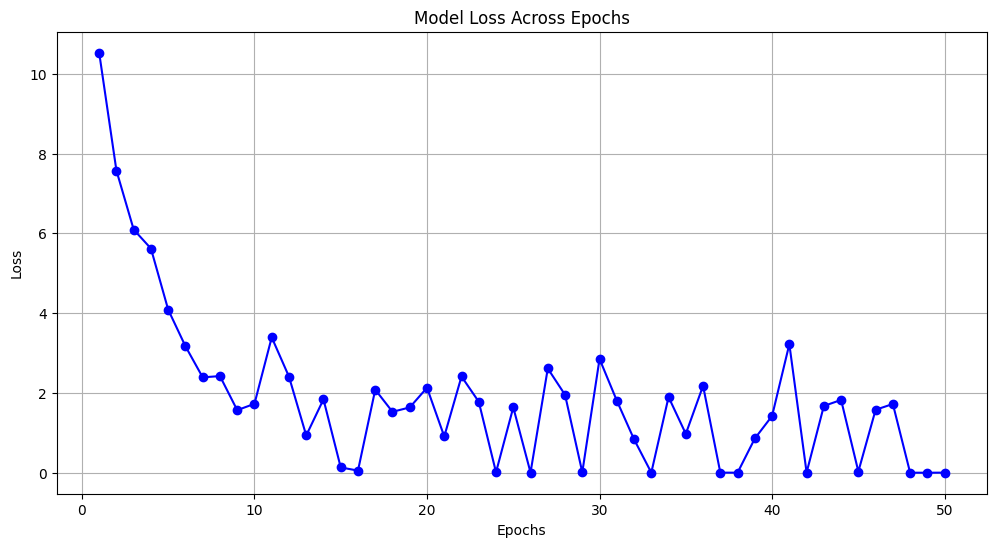

In [ ]:
import matplotlib.pyplot as plt

# Loss values from the training log provided
loss_values = [
    10.524957656860352, 7.573013782501221, 6.093880653381348, 5.619320869445801,
    4.087249279022217, 3.170990228652954, 2.3915534019470215, 2.42336368560791,
    1.5699701309204102, 1.7284307479858398, 3.3935964107513428, 2.409952163696289,
    0.9347993731498718, 1.839994192123413, 0.13441666960716248, 0.055377986282110214,
    2.083299160003662, 1.5283349752426147, 1.6383534669876099, 2.1320436000823975,
    0.9101232290267944, 2.413607358932495, 1.7803207635879517, 0.013463820330798626,
    1.6402473449707031, 0.006504483055323362, 2.6134519577026367, 1.9546501636505127,
    0.012341270223259926, 2.8523168563842773, 1.808958649635315, 0.8384157419204712,
    0.004394365008920431, 1.8983023166656494, 0.9757919311523438, 2.17980694770813,
    0.004207476507872343, 0.003634682623669505, 0.8599268794059753, 1.4244493246078491,
    3.222787380218506, 0.006789436563849449, 1.6747198104858398, 1.825717568397522,
    0.032095201313495636, 1.57936692237854, 1.7242258787155151, 0.0028571824077516794,
    0.0021809032186865807, 0.00432702712714672
]

# Epochs corresponding to the loss values
epochs = list(range(1, len(loss_values) + 1))

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Model Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [22]:

# Generate and refine
new_article = "President announces new economic stimulus package aimed at boosting the economy."
template_headline = generate_template_headline(new_article, vectorizer, lda)
refined_headline = refine_headline(new_article, template_headline)
print(template_headline)
print(refined_headline)

the to of and in Story 😇
former ian native can k killedot


In [32]:

# Generate and refine
new_article = """ It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because he wants to. "While I believe I have the authority to carry out this military action without specific congressional authorization, I know that the country will be stronger if we take this course, and our actions will be even more effective," he said. "We should have this debate, because the issues are too big for business as usual." Obama said top congressional leaders had agreed to schedule a debate when the body returns to Washington on September 9. The Senate Foreign Relations Committee will hold a hearing over the matter on Tuesday, Sen. Robert Menendez said. Transcript: Read Obama's full remarks . Syrian crisis: Latest developments . U.N. inspectors leave Syria . Obama's remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb. "The aim of the game here, the mandate, is very clear -- and that is to ascertain whether chemical weapons were used -- and not by whom," U.N. spokesman Martin Nesirky told reporters on Saturday. But who used the weapons in the reported toxic gas attack in a Damascus suburb on August 21 has been a key point of global debate over the Syrian crisis. Top U.S. officials have said there's no doubt that the Syrian government was behind it, while Syrian officials have denied responsibility and blamed jihadists fighting with the rebels. British and U.S. intelligence reports say the attack involved chemical weapons, but U.N. officials have stressed the importance of waiting for an official report from inspectors. The inspectors will share their findings with U.N. Secretary-General Ban Ki-moon Ban, who has said he wants to wait until the U.N. team's final report is completed before presenting it to the U.N. Security Council. The Organization for the Prohibition of Chemical Weapons, which nine of the inspectors belong to, said Saturday that it could take up to three weeks to analyze the evidence they collected. "It needs time to be able to analyze the information and the samples," Nesirky said. He noted that Ban has repeatedly said there is no alternative to a political solution to the crisis in Syria, and that "a military solution is not an option." Bergen:  Syria is a problem from hell for the U.S. Obama: 'This menace must be confronted' Obama's senior advisers have debated the next steps to take, and the president's comments Saturday came amid mounting political pressure over the situation in Syria. Some U.S. lawmakers have called for immediate action while others warn of stepping into what could become a quagmire. Some global leaders have expressed support, but the British Parliament's vote against military action earlier this week was a blow to Obama's hopes of getting strong backing from key NATO allies. On Saturday, Obama proposed what he said would be a limited military action against Syrian President Bashar al-Assad. Any military attack would not be open-ended or include U.S. ground forces, he said. Syria's alleged use of chemical weapons earlier this month "is an assault on human dignity," the president said. A failure to respond with force, Obama argued,  "could lead to escalating use of chemical weapons or their proliferation to terrorist groups who would do our people harm. In a world with many dangers, this menace must be confronted." Syria missile strike: What would happen next? Map: U.S. and allied assets around Syria . Obama decision came Friday night . On Friday night, the president made a last-minute decision to consult lawmakers. What will happen if they vote no? It's unclear. A senior administration official told CNN that Obama has the authority to act without Congress -- even if Congress rejects his request for authorization to use force. Obama on Saturday continued to shore up support for a strike on the al-Assad government. He spoke by phone with French President Francois Hollande before his Rose Garden speech. "The two leaders agreed that the international community must deliver a resolute message to the Assad regime -- and others who would consider using chemical weapons -- that these crimes are unacceptable and those who violate this international norm will be held accountable by the world," the White House said. Meanwhile, as uncertainty loomed over how Congress would weigh in, U.S. military officials said they remained at the ready. 5 key assertions: U.S. intelligence report on Syria . Syria: Who wants what after chemical weapons horror . Reactions mixed to Obama's speech . A spokesman for the Syrian National Coalition said that the opposition group was disappointed by Obama's announcement. "Our fear now is that the lack of action could embolden the regime and they repeat his attacks in a more serious way," said spokesman Louay Safi. "So we are quite concerned." Some members of Congress applauded Obama's decision. House Speaker John Boehner, Majority Leader Eric Cantor, Majority Whip Kevin McCarthy and Conference Chair Cathy McMorris Rodgers issued a statement Saturday praising the president. "Under the Constitution, the responsibility to declare war lies with Congress," the Republican lawmakers said. "We are glad the president is seeking authorization for any military action in Syria in response to serious, substantive questions being raised." More than 160 legislators, including 63 of Obama's fellow Democrats, had signed letters calling for either a vote or at least a "full debate" before any U.S. action. British Prime Minister David Cameron, whose own attempt to get lawmakers in his country to support military action in Syria failed earlier this week, responded to Obama's speech in a Twitter post Saturday. "I understand and support Barack Obama's position on Syria," Cameron said. An influential lawmaker in Russia -- which has stood by Syria and criticized the United States -- had his own theory. "The main reason Obama is turning to the Congress:  the military operation did not get enough support either in the world, among allies of the US or in the United States itself," Alexei Pushkov, chairman of the international-affairs committee of the Russian State Duma, said in a Twitter post. In the United States, scattered groups of anti-war protesters around the country took to the streets Saturday. "Like many other Americans...we're just tired of the United States getting involved and invading and bombing other countries," said Robin Rosecrans, who was among hundreds at a Los Angeles demonstration. What do Syria's neighbors think? Why Russia, China, Iran stand by Assad . Syria's government unfazed . After Obama's speech, a military and political analyst on Syrian state TV said Obama is "embarrassed" that Russia opposes military action against Syria, is "crying for help" for someone to come to his rescue and is facing two defeats -- on the political and military levels. Syria's prime minister appeared unfazed by the saber-rattling. "The Syrian Army's status is on maximum readiness and fingers are on the trigger to confront all challenges," Wael Nader al-Halqi said during a meeting with a delegation of Syrian expatriates from Italy, according to a banner on Syria State TV that was broadcast prior to Obama's address. An anchor on Syrian state television said Obama "appeared to be preparing for an aggression on Syria based on repeated lies." A top Syrian diplomat told the state television network that Obama was facing pressure to take military action from Israel, Turkey, some Arabs and right-wing extremists in the United States. "I think he has done well by doing what Cameron did in terms of taking the issue to Parliament," said Bashar Jaafari, Syria's ambassador to the United Nations. Both Obama and Cameron, he said, "climbed to the top of the tree and don't know how to get down." The Syrian government has denied that it used chemical weapons in the August 21 attack, saying that jihadists fighting with the rebels used them in an effort to turn global sentiments against it. British intelligence had put the number of people killed in the attack at more than 350. On Saturday, Obama said "all told, well over 1,000 people were murdered." U.S. Secretary of State John Kerry on Friday cited a death toll of 1,429, more than 400 of them children. No explanation was offered for the discrepancy. Iran: U.S. military action in Syria would spark 'disaster' Opinion: Why strikes in Syria are a bad idea . """
template_headline = generate_template_headline(new_article, vectorizer, lda)
refined_headline = refine_headline(new_article, template_headline)
print(template_headline)
print(refined_headline)

U.S. Announces New the in to of and 😇
 says  speed to history of of on that ian native usachi


reference headlines

In [ ]:
# Syrian official: Obama climbed to the top of the tree, "doesn't know how to get down"
# Obama sends a letter to the heads of the House and Senate .
# Obama to seek congressional approval on military action against Syria .
# Aim is to determine whether CW were used, not by whom, says U.N. spokesman .

In [23]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=b3f038ffcd97bcfc9cd6f1ad56de5034a57344b220c3033f917332b5faed9afc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [24]:

def evaluate_headlines(generated_headlines, reference_headlines):
    """
    Evaluates the generated headlines using ROUGE and BLEU metrics.

    Args:
    - generated_headlines (list of str): The list of generated headlines.
    - reference_headlines (list of str): The list of reference headlines.

    Returns:
    - dict: A dictionary containing the ROUGE and BLEU scores.
    """
    # Load the ROUGE and BLEU metrics
    rouge = load_metric("rouge")
    bleu = load_metric("bleu")

    # Calculate ROUGE scores
    rouge_scores = rouge.compute(predictions=generated_headlines, references=reference_headlines)

    # Prepare BLEU input
    generated_for_bleu = [headline.split() for headline in generated_headlines]
    reference_for_bleu = [[headline.split()] for headline in reference_headlines]

    # Calculate BLEU scores
    bleu_scores = bleu.compute(predictions=generated_for_bleu, references=reference_for_bleu)

    # Combine and return results
    return {
        "rouge": rouge_scores,
        "bleu": bleu_scores
    }


the day Announces New the of and to in 😊
 the thea  the on for   that is on


In [25]:
def print_evaluation_scores(scores):
    """
    Prints the ROUGE and BLEU scores.

    Args:
    - scores (dict): A dictionary containing the ROUGE and BLEU scores.
    """
    rouge_scores = scores["rouge"]
    bleu_scores = scores["bleu"]

    print("ROUGE Scores:")
    print("--------------")
    for metric, score in rouge_scores.items():
        print(f"{metric}: {score['mid']['f']:.4f}")

    print("\nBLEU Score:")
    print("--------------")
    print(f"BLEU-4: {bleu_scores['score']:.4f}")


In [33]:

# Example usage
generated = ["U.S. Announces New the in to of and 😇 U.S. Announces New the in to of and 😇 says  speed to history of of on that ian native usachi"]
references = ['Obama to seek congressional approval on military action against Syria']

scores = evaluate_headlines(generated, references)
print(scores)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)), 'rougeL': AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257)), 'rougeLsum': AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0.2

In [34]:
def print_dictionary(d, indent=0):
    for key, value in d.items():
        print(' ' * indent + str(key) + ':', end=' ')
        if isinstance(value, dict):
            print()  # Move to the next line before printing nested dictionary
            print_dictionary(value, indent + 4)
        else:
            print(value)


In [35]:
print_dictionary(scores)

rouge: 
    rouge1: AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257))
    rouge2: AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0))
    rougeL: AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257))
    rougeLsum: AggregateScore(low=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), mid=Score(precision=0.06896551724137931, recall=0.2, fmeasure=0.10256410256410257), high=Score(precision=0.06896551724137931, recall=0

In [ ]:

# Example usage
generated = ["secret the can disclresses on vastalun in to killed"]
references = ["julian zelizer  criticism of obama foreign policy has been on the increase"]

# scores2 = evaluate_headlines(generated, references)
# print(scores2)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905), mid=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905), high=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)), 'rougeL': AggregateScore(low=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), mid=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), high=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525)), 'rougeLsum': AggregateScore(low=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), mid=Score(precision=0.111111111111

In [ ]:
# print_dictionary(scores2)

rouge: 
    rouge1: AggregateScore(low=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905), mid=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905), high=Score(precision=0.2222222222222222, recall=0.16666666666666666, fmeasure=0.1904761904761905))
    rouge2: AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0))
    rougeL: AggregateScore(low=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), mid=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), high=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525))
    rougeLsum: AggregateScore(low=Score(precision=0.1111111111111111, recall=0.08333333333333333, fmeasure=0.09523809523809525), mid=Score(precision=0.1111111111

In [36]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def preprocess_text(text):
    """
    Preprocess the input text by tokenizing and lowercasing it.
    :param text: Input text.
    :return: Preprocessed text as a list of tokens.
    """
    return text.lower().split()

def cosine_similarity_text(text1, text2):
    """
    Calculate cosine similarity between two texts based on their tokenized representations.
    :param text1: First text.
    :param text2: Second text.
    :return: Cosine similarity score.
    """
    # Tokenize and preprocess the texts
    tokens1 = preprocess_text(text1)
    tokens2 = preprocess_text(text2)

    # Combine the tokens for vocabulary creation
    combined_tokens = list(set(tokens1 + tokens2))

    # Create CountVectorizer with combined vocabulary
    vectorizer = CountVectorizer(vocabulary=combined_tokens)

    # Transform the texts into TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform([text1, text2])

    # Compute the cosine similarity between the vectors
    similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
    return similarity[0][0]

# Proper usage with strings for the text comparison:
generated = "secret the can disclresses on vastalun in to killed"
references = "julian zelizer  criticism of obama foreign policy has been on the increase"
similarity_score = cosine_similarity_text(generated, references)
print(f"Cosine Similarity for Generated vs References: {similarity_score}")


Cosine Similarity for Generated vs References: 0.19245008972987526


In [ ]:
# !pip install numpy pandas gensim nltk pytorch transformers streamlit


In [ ]:
# import numpy as np
# import pandas as pd
# from gensim.models import Word2Vec
# from gensim.models.ldamodel import LdaModel
# from gensim import corpora
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from transformers import BartForConditionalGeneration, BartTokenizer
# import streamlit as st


In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_articles, vector_size=100, window=5, min_count=1, workers=4)
#

In [ ]:
# # Create dictionary and corpus
# dictionary = corpora.Dictionary(tokenized_articles)
# corpus = [dictionary.doc2bow(article) for article in tokenized_articles]

# # Train LDA model
# lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)


In [ ]:
# # Create dictionary and corpus
# dictionary = corpora.Dictionary(tokenized_articles)
# corpus = [dictionary.doc2bow(article) for article in tokenized_articles]

# # Train LDA model
# lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)


In [ ]:
# # Load BART model and tokenizer
# bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


In [ ]:
# # Streamlit app
# st.title("News Headline Generator")

# # User input
# selected_article = st.selectbox("Select an article:", articles)

# # Function to generate headline using BART model
# def generate_headline(article):
#     inputs = tokenizer.encode("summarize: " + article, return_tensors="pt", max_length=1024, truncation=True)
#     summary_ids = bart_model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
#     headline = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#     return headline

# # Generate headline using BART
# generated_headline = generate_headline(selected_article)

# # Display generated headline
# st.subheader("Generated Headline:")
# st.write(generated_headline)


In [ ]:
# ! pip install streamlit -q
# !wget -q -O - ipv4.icanhazip.com
# ! streamlit run app.py & npx localtunnel --port 8501